# Exploring Tesser Data Using Succersor Representation  Models


In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import math
import pandas as pd
import csv
import sys
import os

In [2]:


path = '/home/rodrigo/Dropbox/tesser_successor/Data/'
# path = input("Enter directory of data as string '':")

# simple for loop to obtain all data .txt files including subdirectories.
files = []
# r=root, d=directories, f = files
for r, d, f in os.walk(path):
    for file in f:
        if '.txt' in file:
            files.append(os.path.join(r, file))
            
            
# list of file paths for the required data            
listd=[]
for f in files:
    listd.append(f)
#     print(f)
listd.sort()
# print(listd)

names= pd.DataFrame(np.array(listd).reshape(len(listd),1),columns=[" Directory Names"])
pd.set_option('display.max_colwidth', -1)
# print(names)
# print()


# list of data labels to use as keys
dl=[]
# dictionary of data sets with data labels
data={}


for i in range (len(listd)):
    s = listd[i]
    lb = s[44:]
    dl.append(lb)
    Test = pd.read_csv(s,sep="\t")#[' objnum']
    Test.replace([" NaN"], np.nan, inplace = True) # Drops NaN values from DataFrame
    Test = Test.dropna()
    b = Test.reset_index(drop=True) # Resets the index to start at 0
    data[lb] = b

print(dl[270])
data[dl[270]].head(5)

tesserScan_125_DS/tesserScan_125_DS_StructLearn_Part2_Run_2.txt


,SubjNum,run,trial,seqtype,objnum,file,orientnam,orientnum,resp,respnum,acc,rt
0,125,2,3,1,21,object_18.jpg,cor,1,c,1,1,0.758876
1,125,2,4,1,3,object_6.jpg,cor,1,c,1,1,0.614788
2,125,2,5,1,20,object_30.jpg,cor,1,c,1,1,0.600684
3,125,2,6,1,18,object_36.jpg,cor,1,c,1,1,0.835284
4,125,2,7,1,21,object_18.jpg,cor,1,c,1,1,0.544599


In [3]:
# Dictionaries meant to individually extract data attributes needed

objnum ={}# object sequence number
trial = {}# trial number
rt ={}# responce/reaction time

for z in range(len(dl)):
#     print(dl[z])
    objnum[dl[z]]=data[dl[z]][' objnum']
    trial[dl[z]]=data[dl[z]][' trial']
    rt[dl[z]]=data[dl[z]][' rt']

def get_objnum(num):
#     print(dl[num])
    return objnum[dl[num]]
print(get_objnum(6).head())


0     6 
1     10
2     8 
3     9 
4     7 
Name:  objnum, dtype: object


In [4]:

# Derived from explore_simulations.py by Demetrius Rowland
def make_envstep(direct_num):
    envstep = []
    objects = get_objnum(direct_num)
    index = 0

    for index in range ( len(objects) ):
        obj = int(objects[index])
        try:
            envstep.append (obj)
        except:
            pass
    return envstep

In [5]:

'''
 SR_no_action reduced version
'''
reward = 1 # for our purposes we will keep the reward parameter constant

class SR_Matrix():

	def __init__(self, gamma, alpha, p_sample, NUM_STATES):
		self.gamma = gamma # discount factor
		self.alpha = alpha # learning rate
		self.p_sample = p_sample # p(sampling options)		
		self.M= np.zeros([NUM_STATES, NUM_STATES]) # M: state-state SR    	
		self.onehot=np.eye(NUM_STATES) # onehot matrix, for updating M
		
	def step(self, s, s_new):

		self.update_SR(s, s_new)
        


	def update_SR(self, s, s_new):
		self.M[s] = (1-self.alpha)* self.M[s] + self.alpha * ( self.onehot[s] + self.gamma * self.M[s_new]  )
		
	

In [6]:

def SRclass_nathum_exp1(envstep, gamma, alpha, p_sample=None):


    if p_sample==None:
        p_sample= [.5,.5]
        
    num_states = 21

    SR_agent = SR_Matrix(gamma, alpha, p_sample, num_states)
    s = envstep[0]-1
    
    for entry in envstep[1:]: # go through trajectory till the end
            
        s_new = entry-1
        SR_agent.step (s, s_new)
            
        s = s_new


    return SR_agent.M



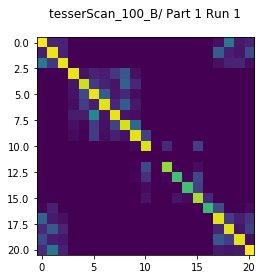

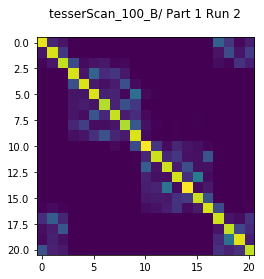

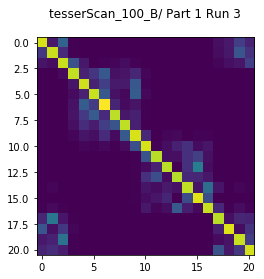

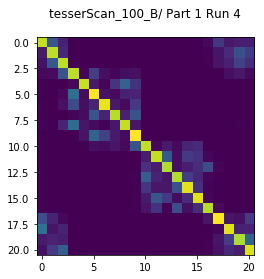

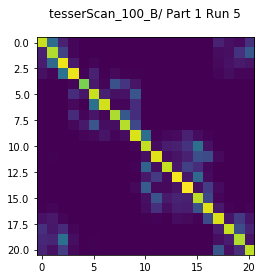

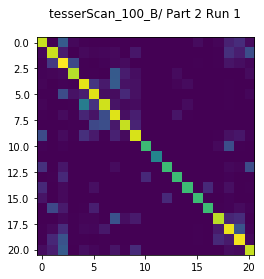

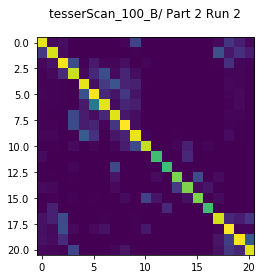

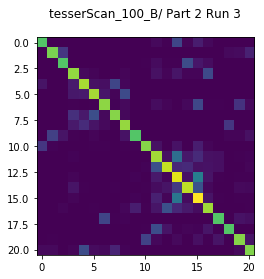

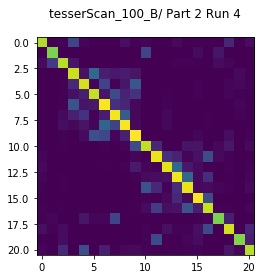

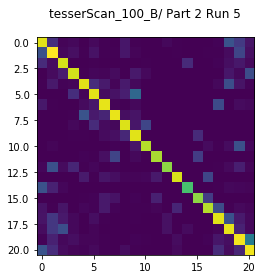

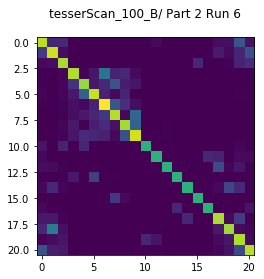

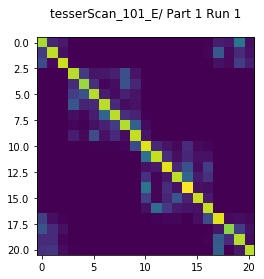

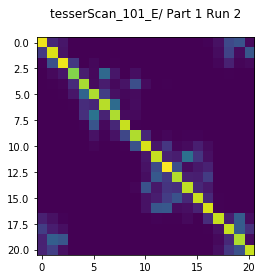

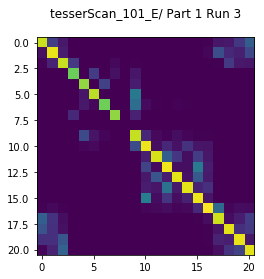

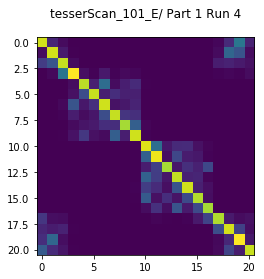

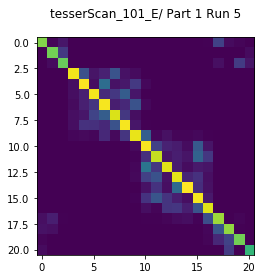

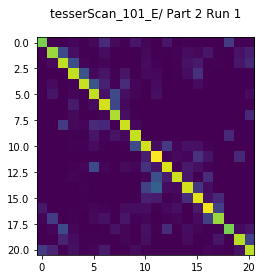

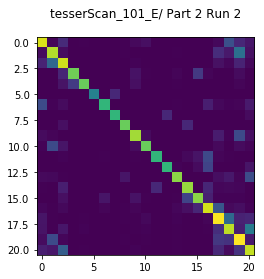

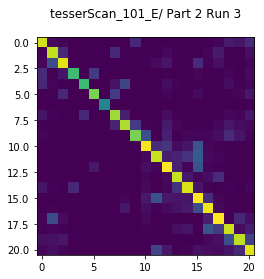

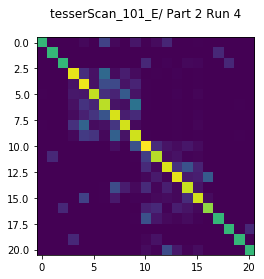

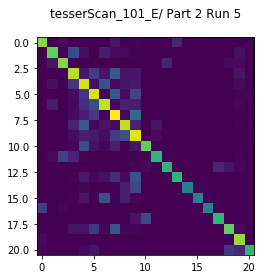

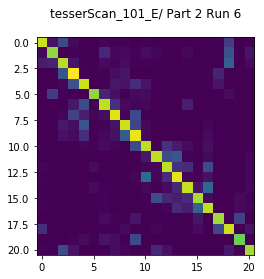

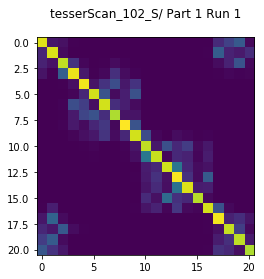

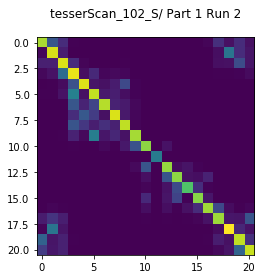

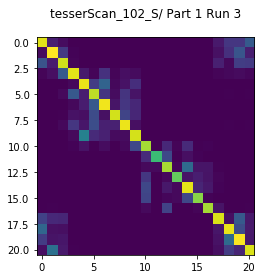

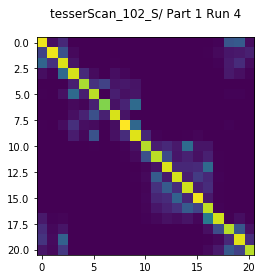

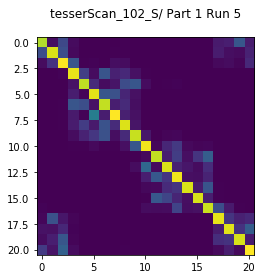

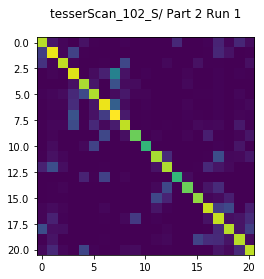

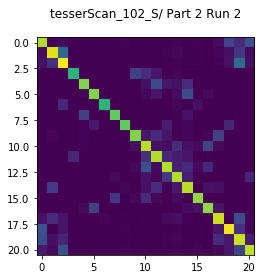

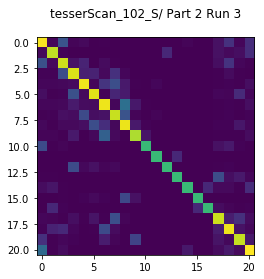

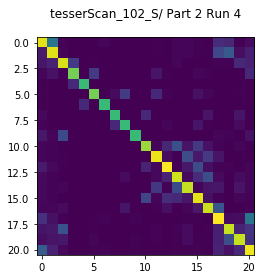

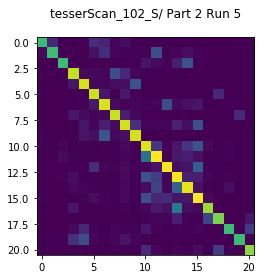

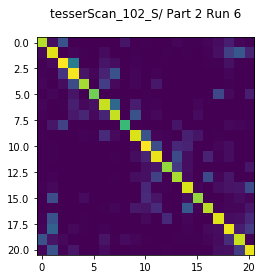

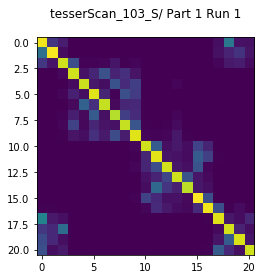

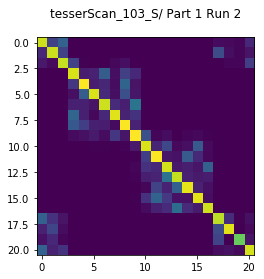

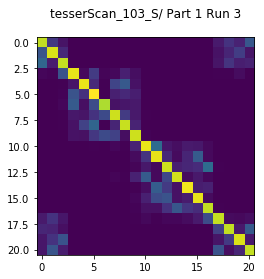

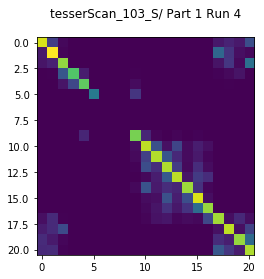

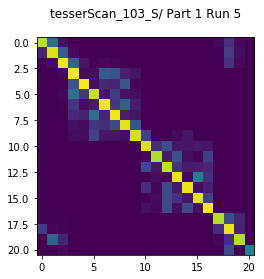

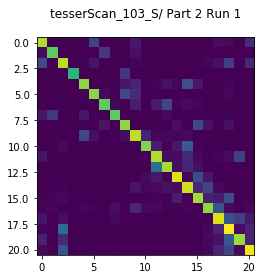

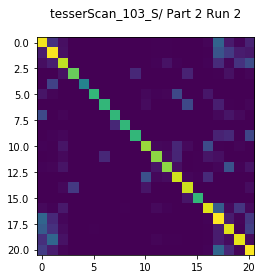

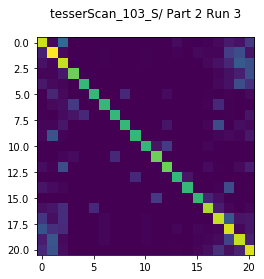

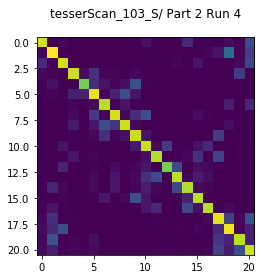

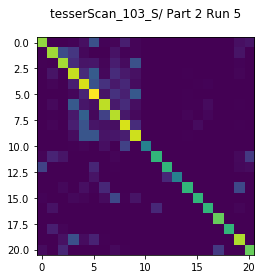

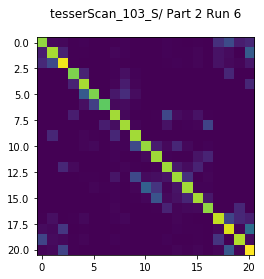

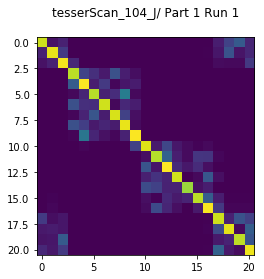

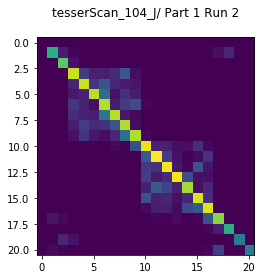

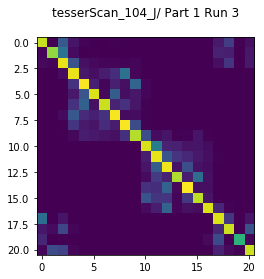

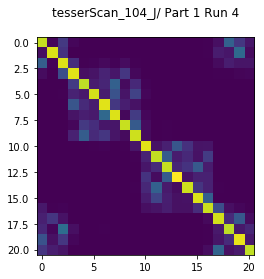

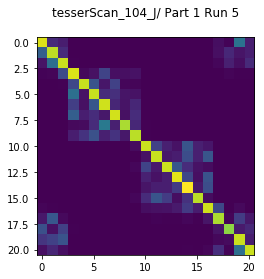

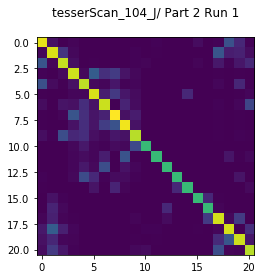

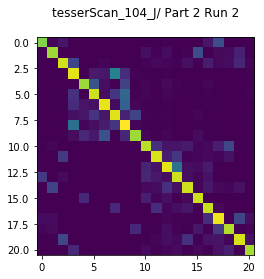

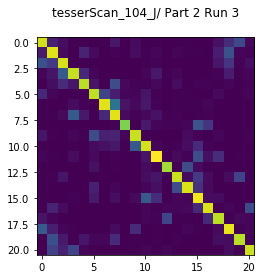

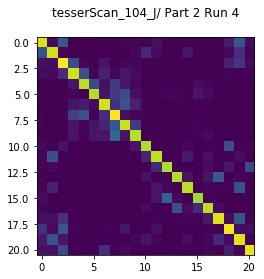

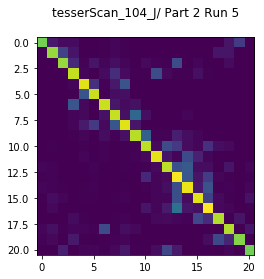

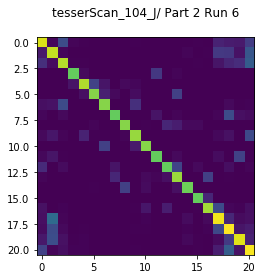

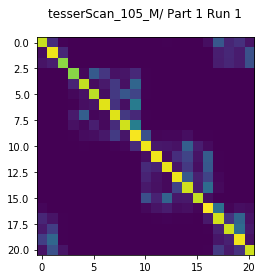

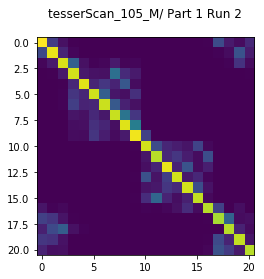

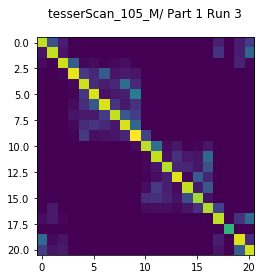

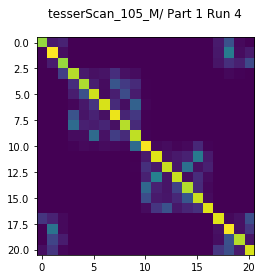

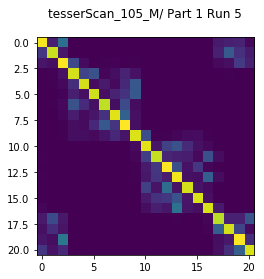

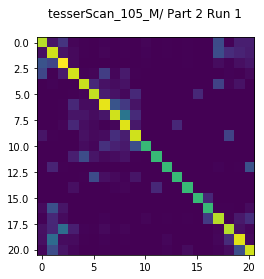

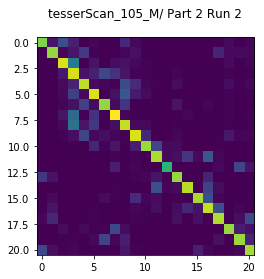

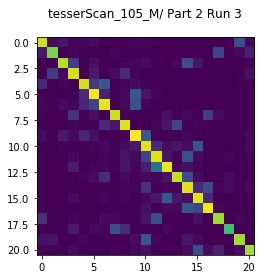

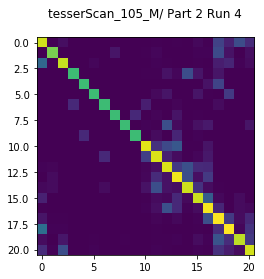

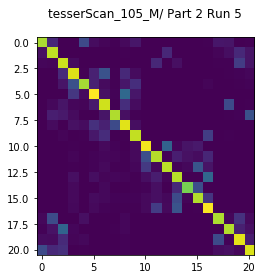

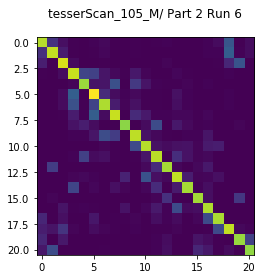

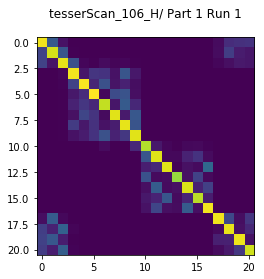

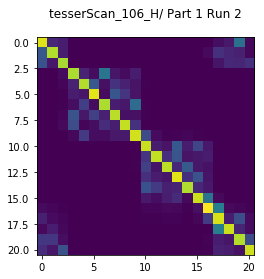

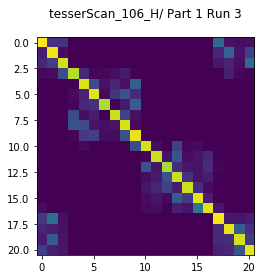

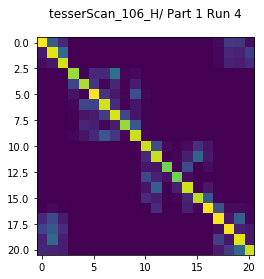

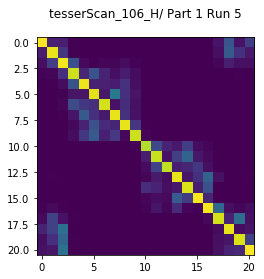

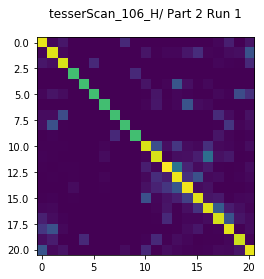

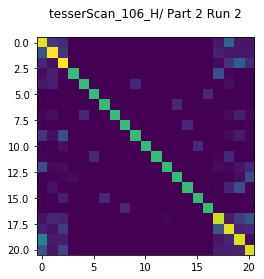

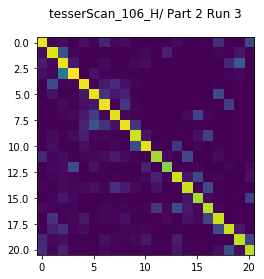

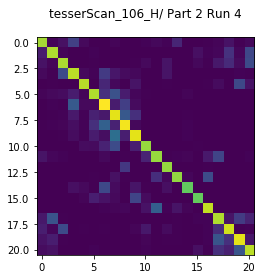

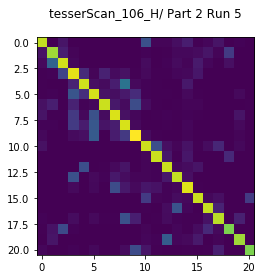

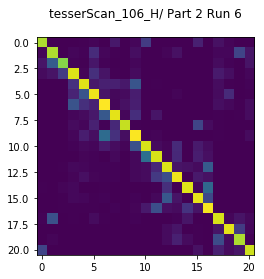

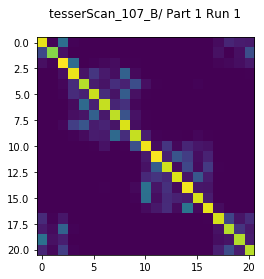

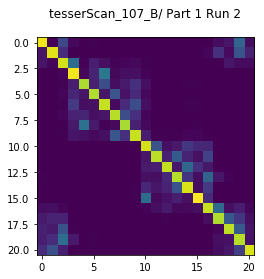

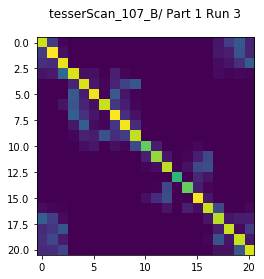

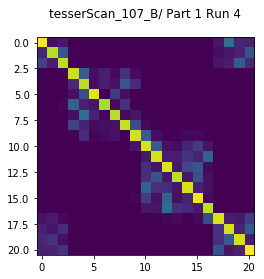

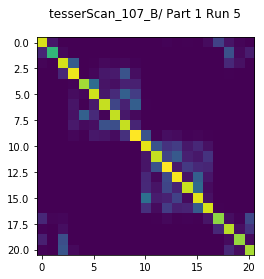

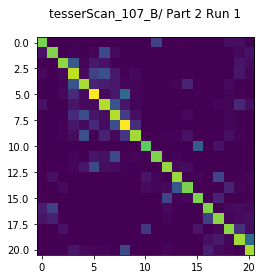

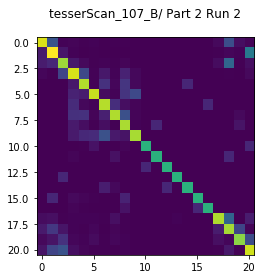

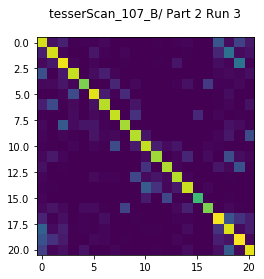

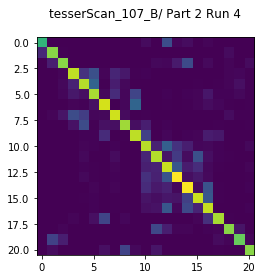

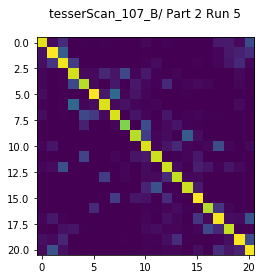

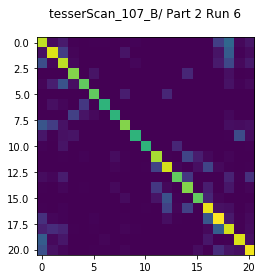

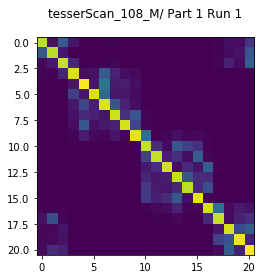

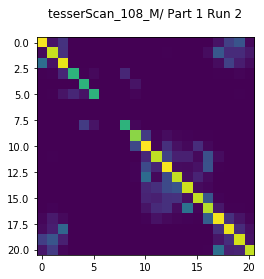

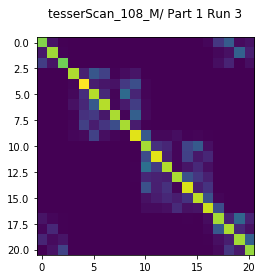

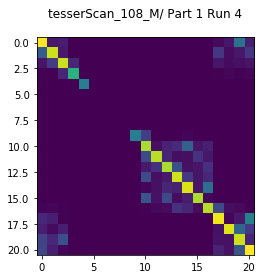

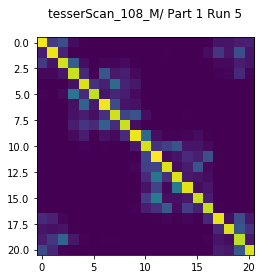

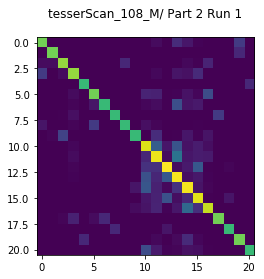

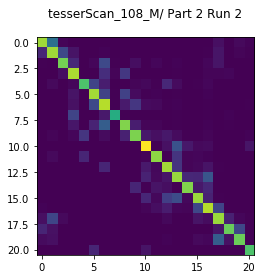

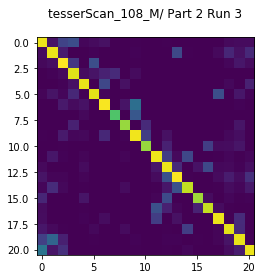

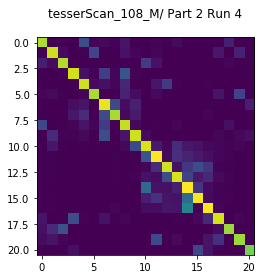

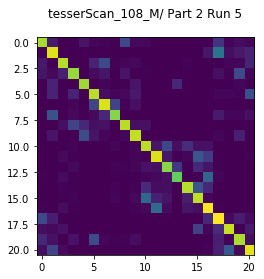

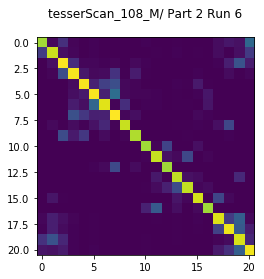

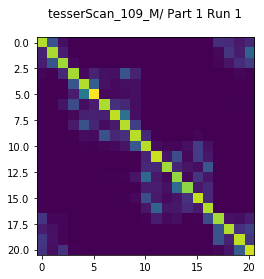

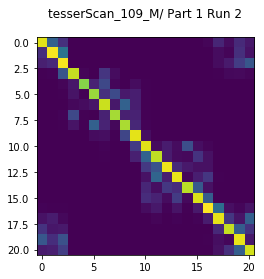

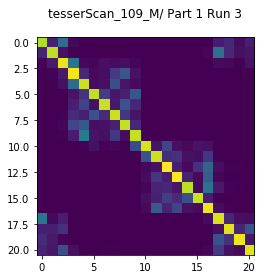

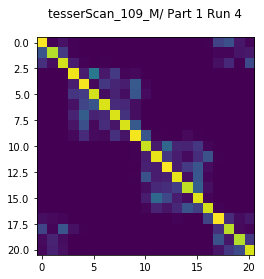

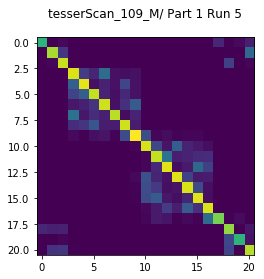

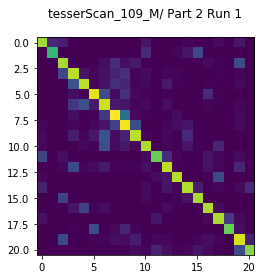

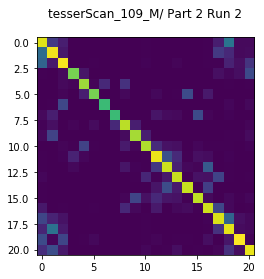

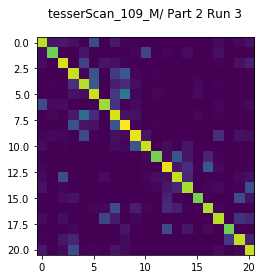

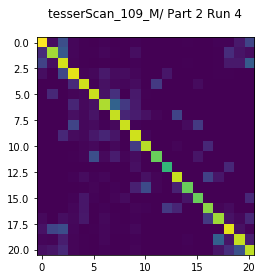

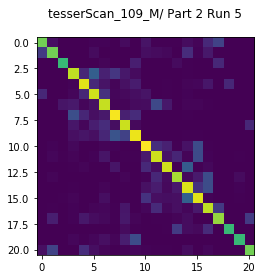

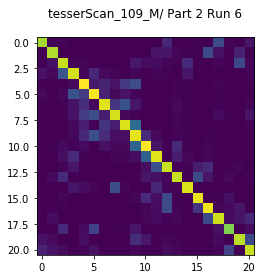

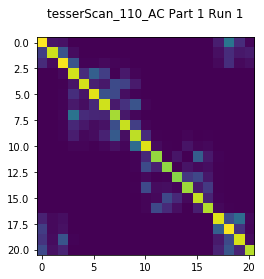

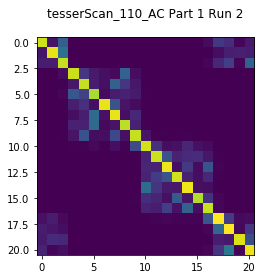

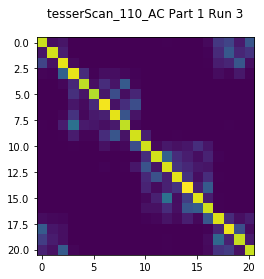

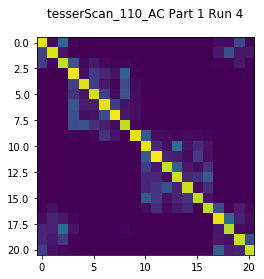

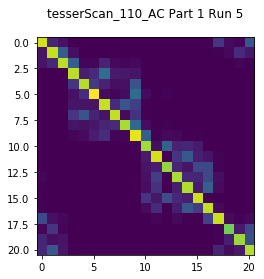

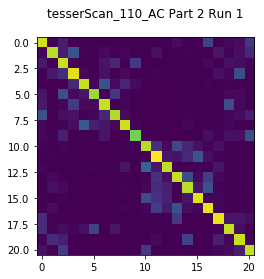

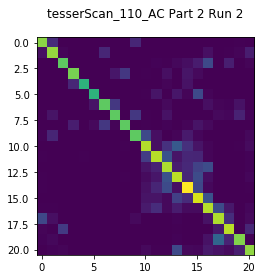

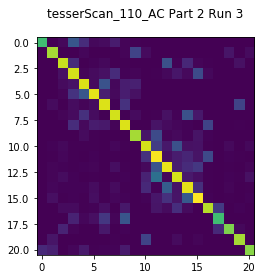

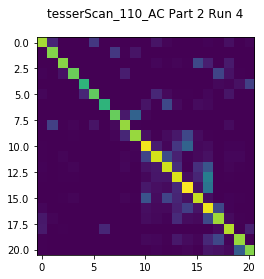

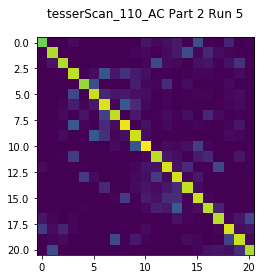

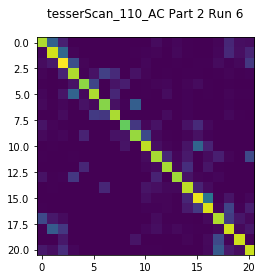

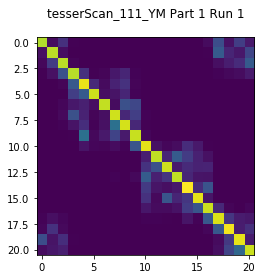

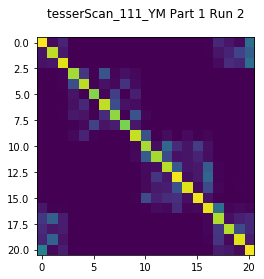

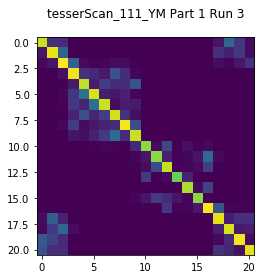

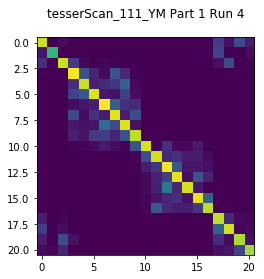

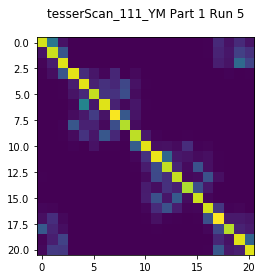

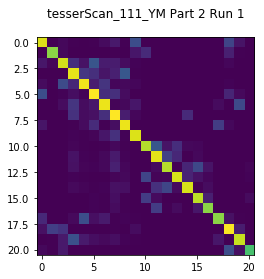

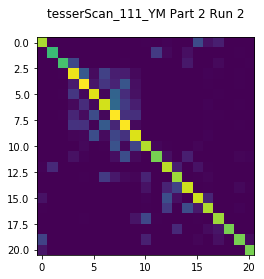

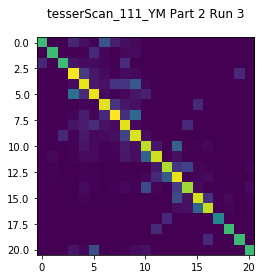

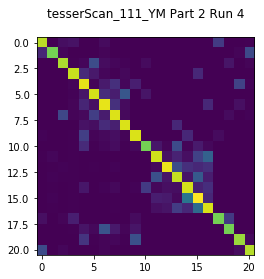

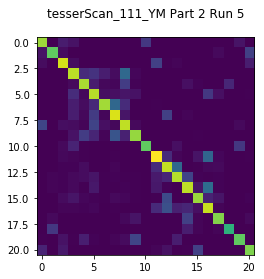

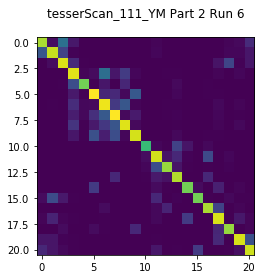

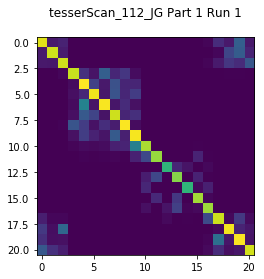

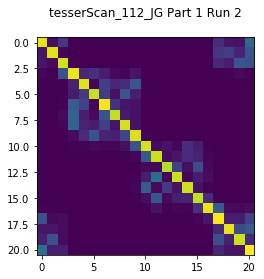

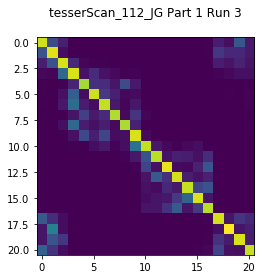

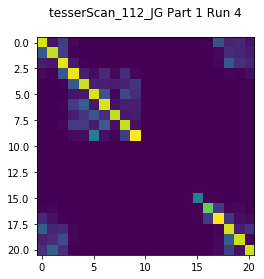

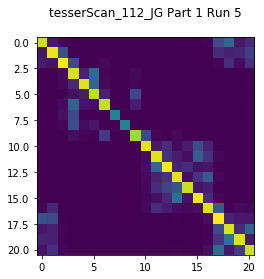

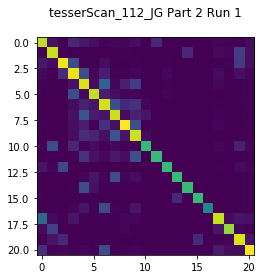

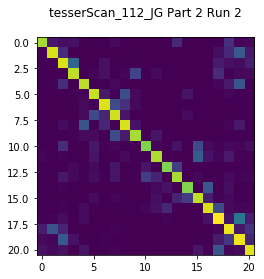

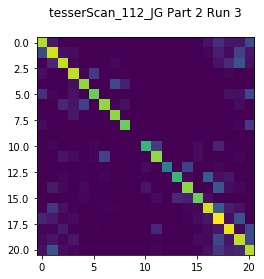

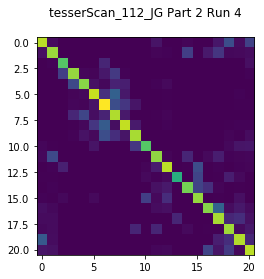

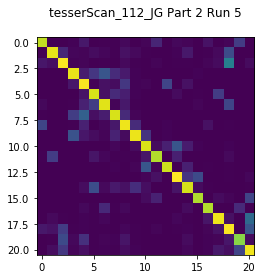

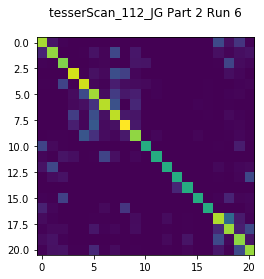

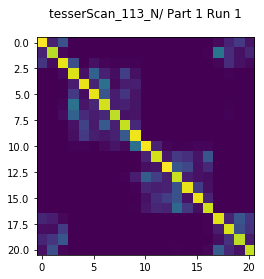

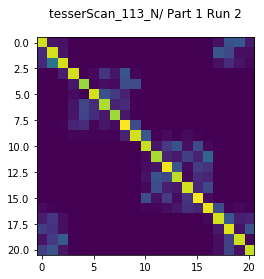

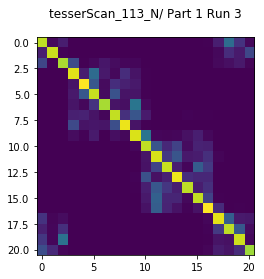

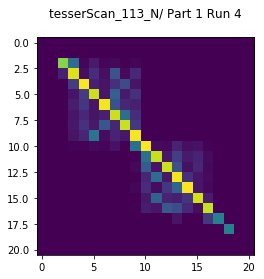

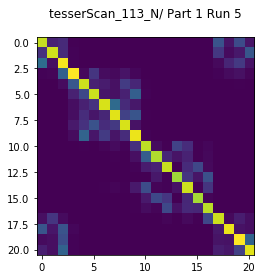

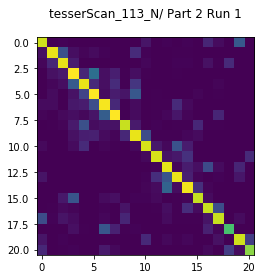

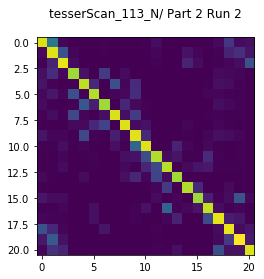

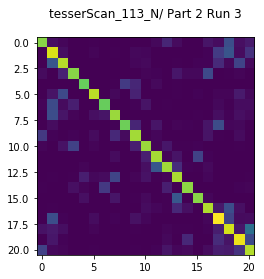

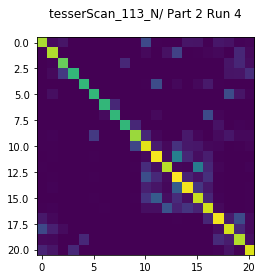

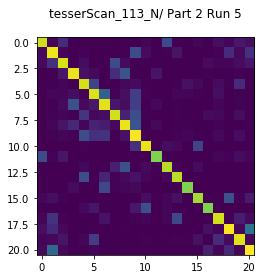

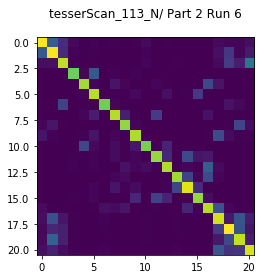

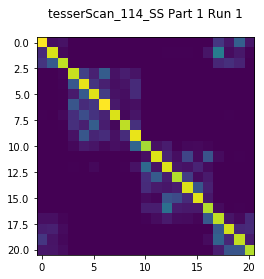

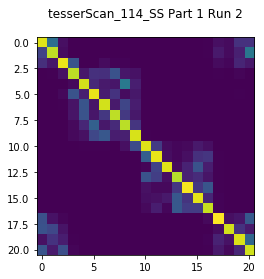

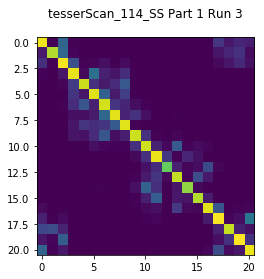

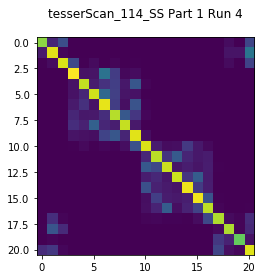

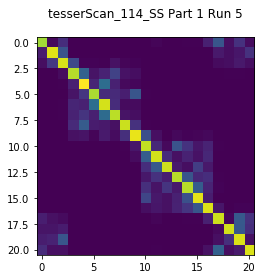

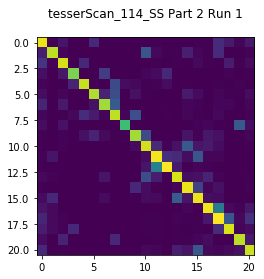

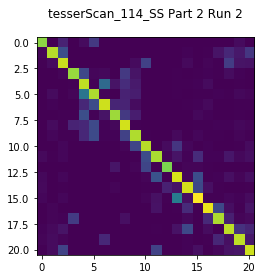

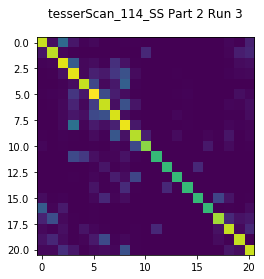

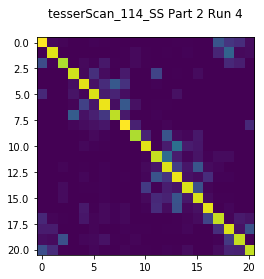

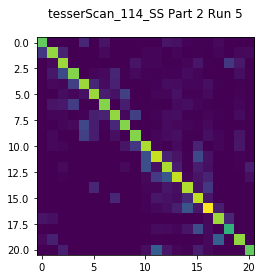

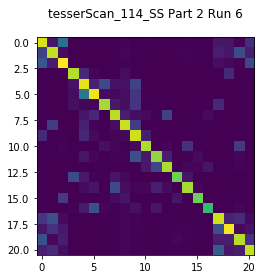

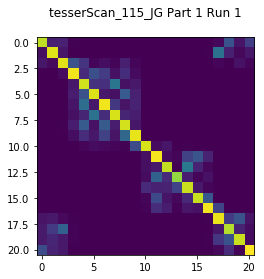

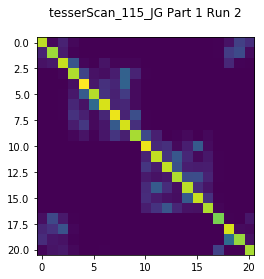

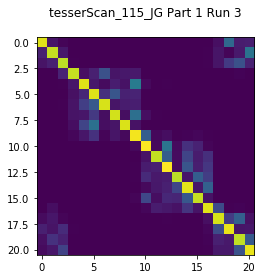

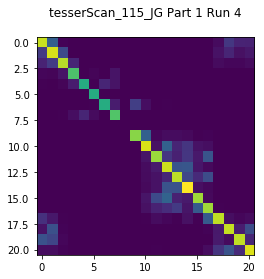

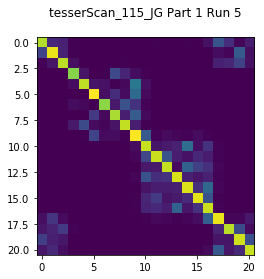

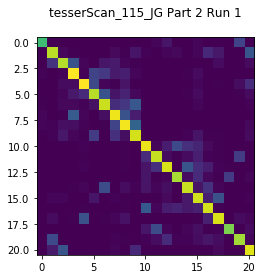

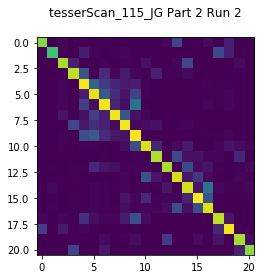

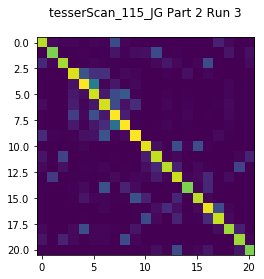

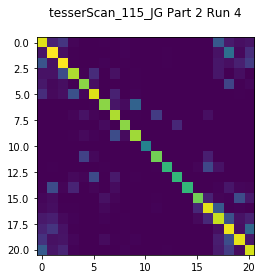

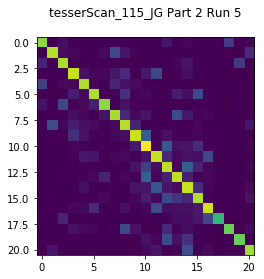

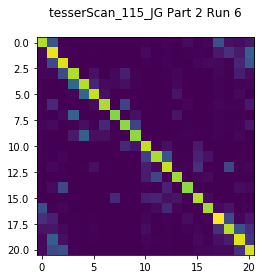

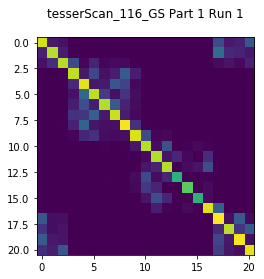

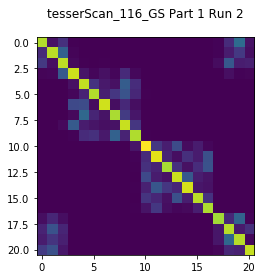

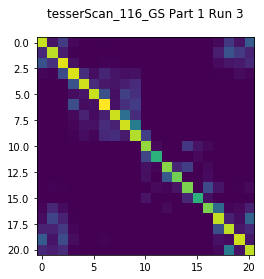

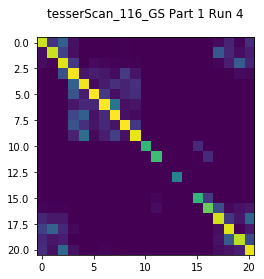

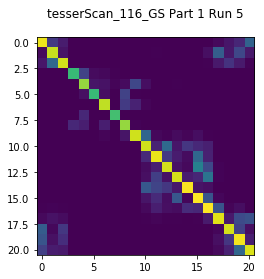

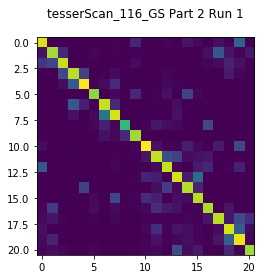

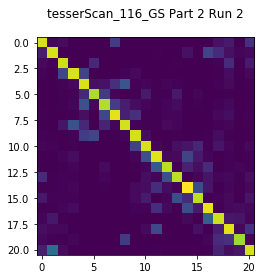

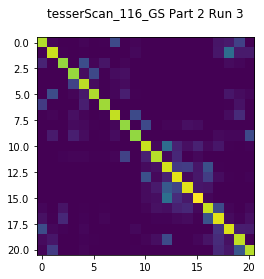

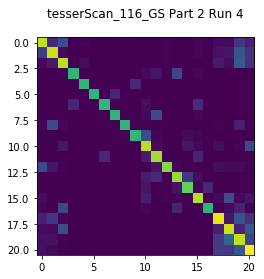

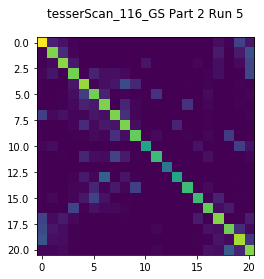

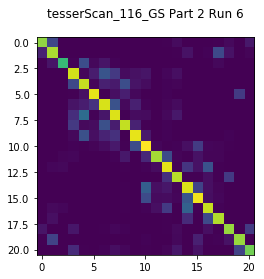

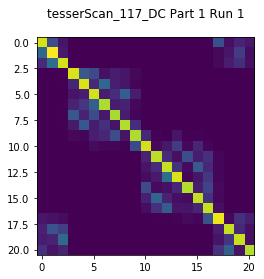

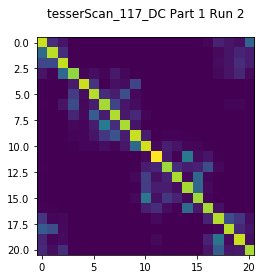

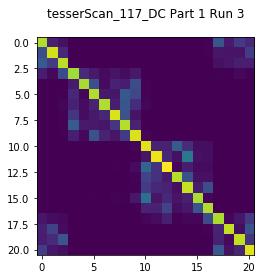

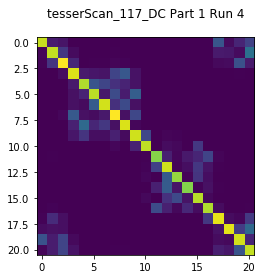

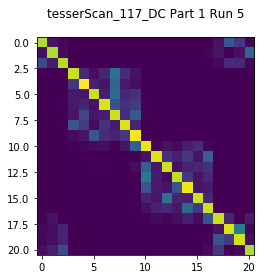

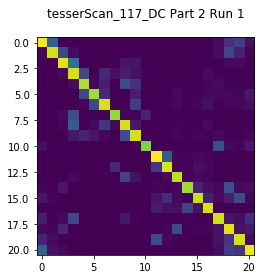

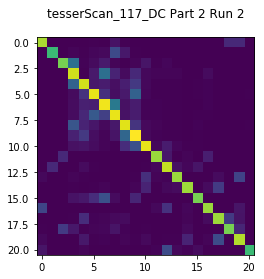

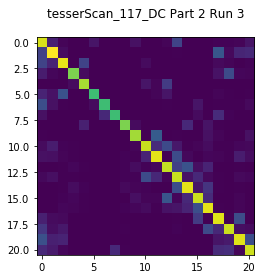

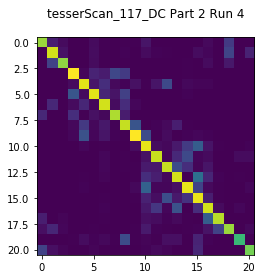

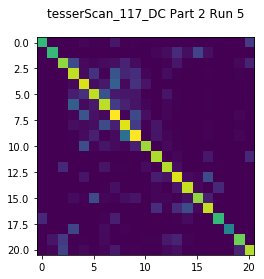

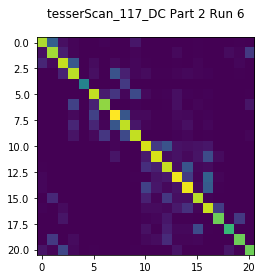

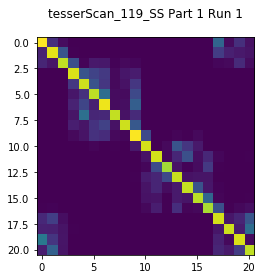

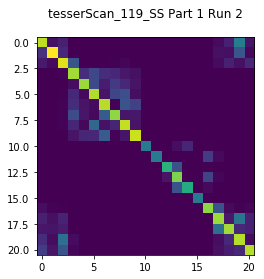

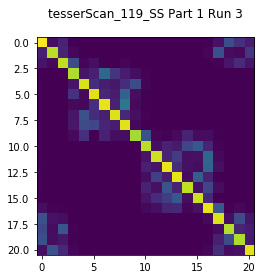

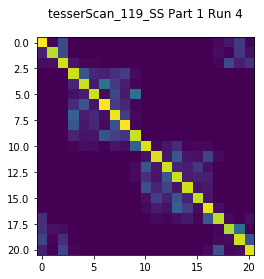

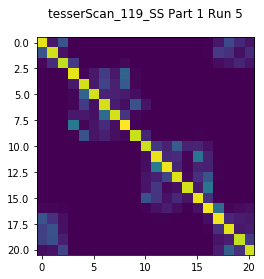

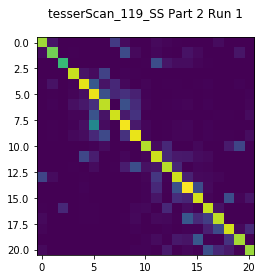

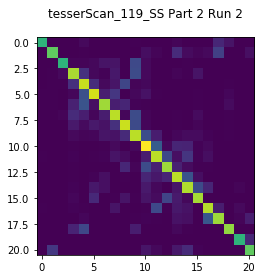

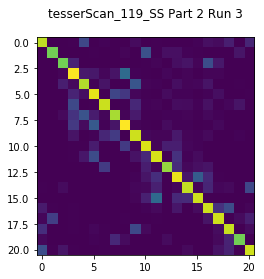

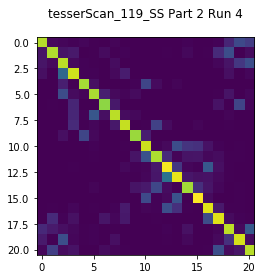

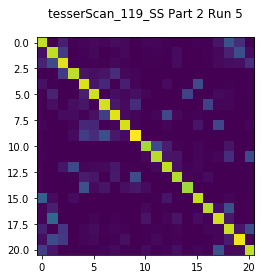

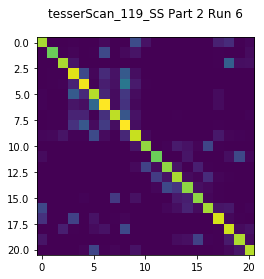

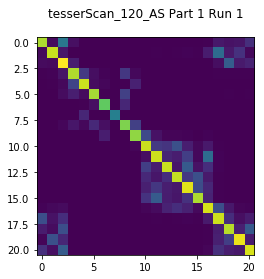

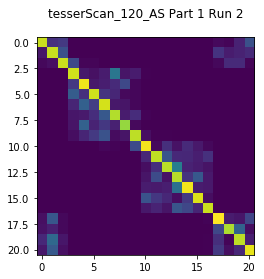

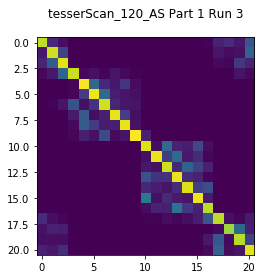

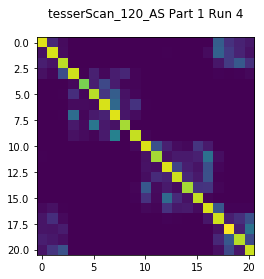

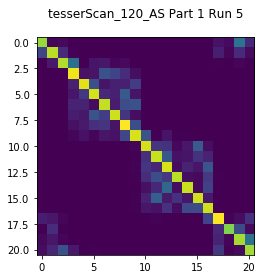

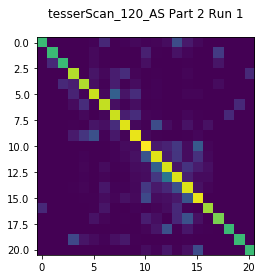

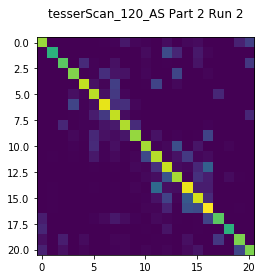

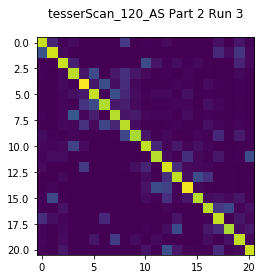

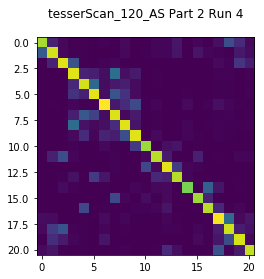

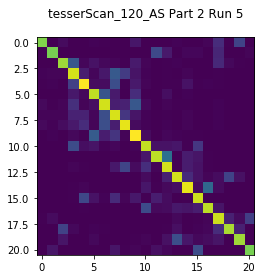

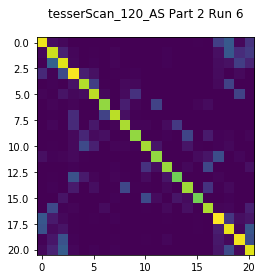

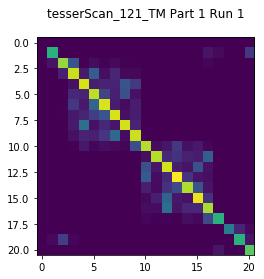

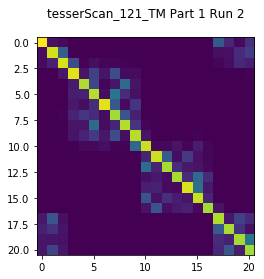

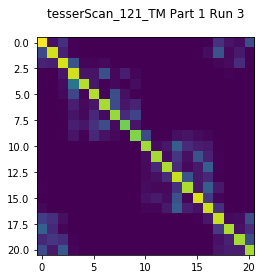

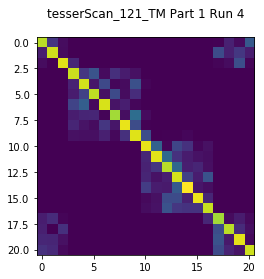

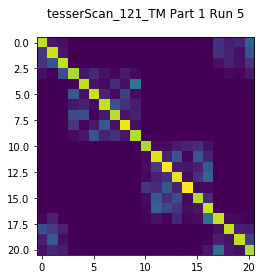

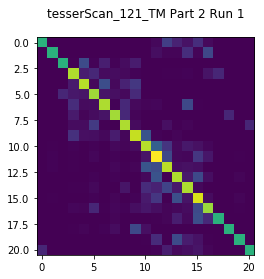

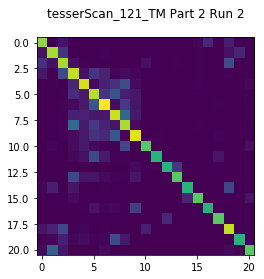

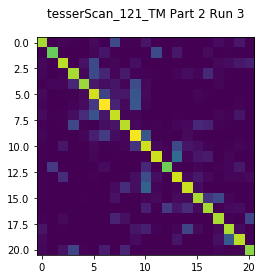

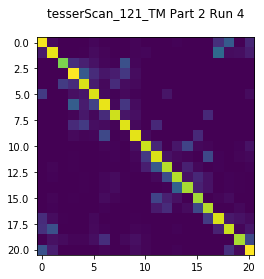

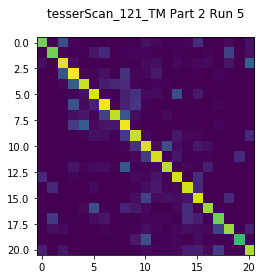

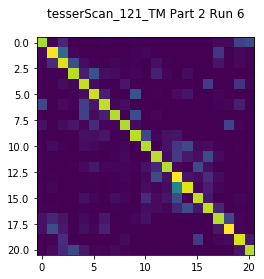

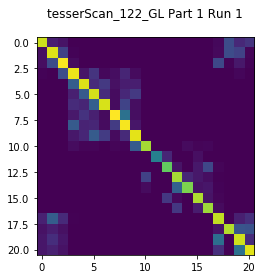

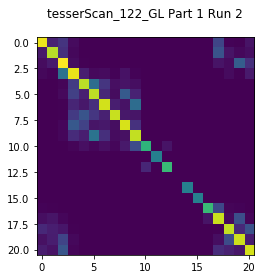

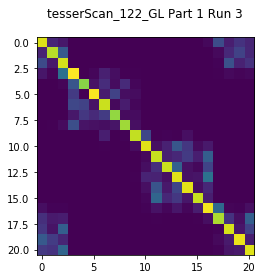

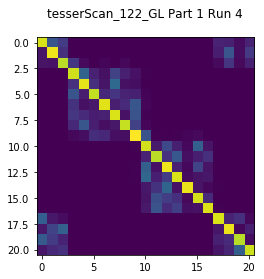

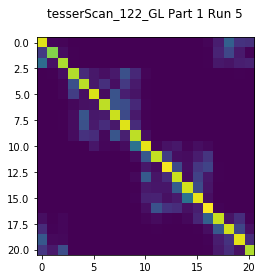

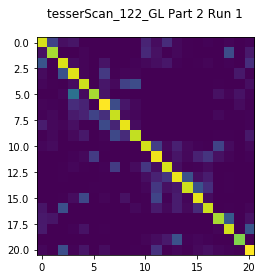

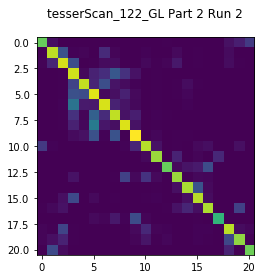

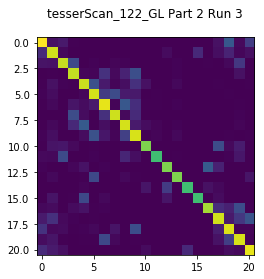

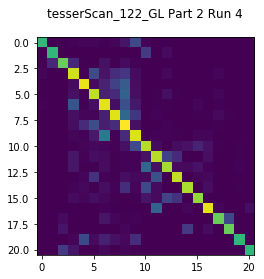

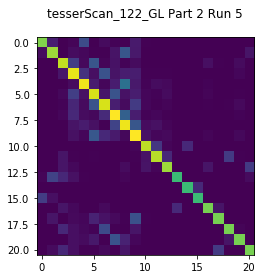

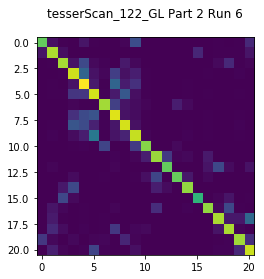

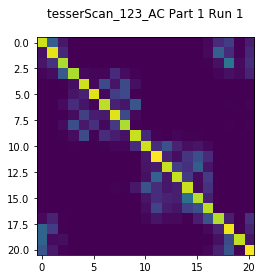

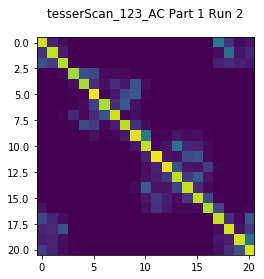

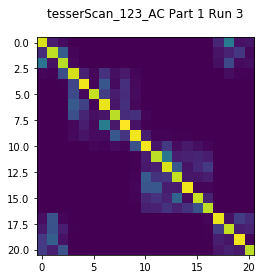

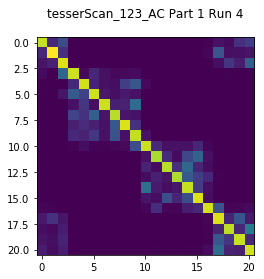

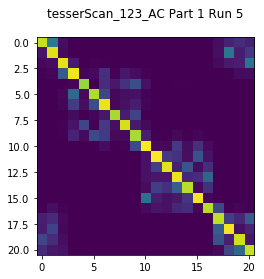

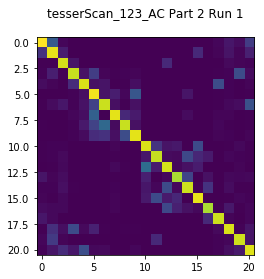

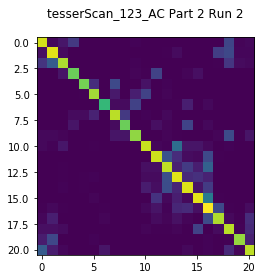

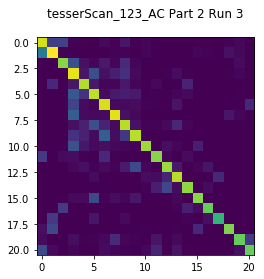

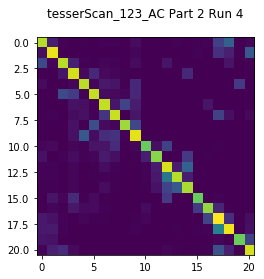

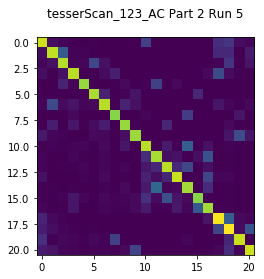

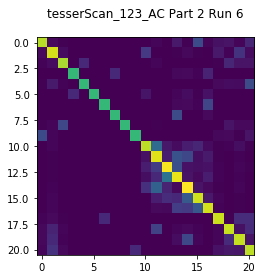

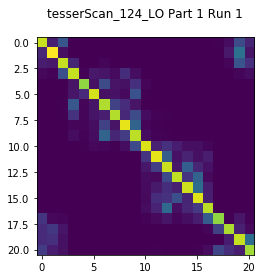

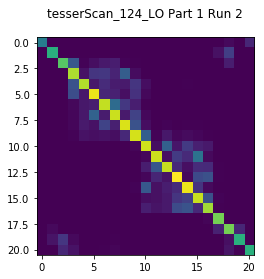

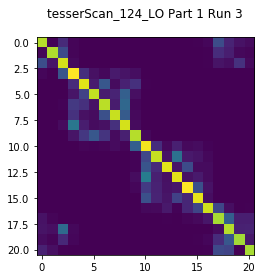

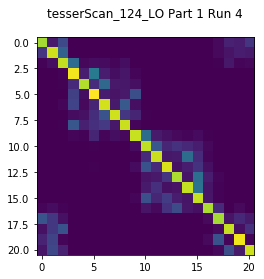

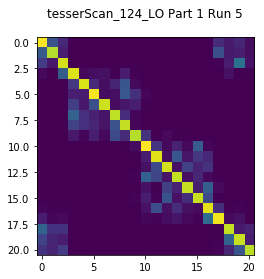

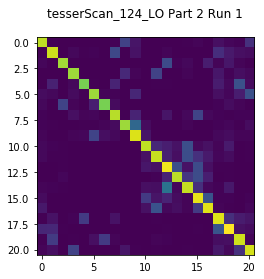

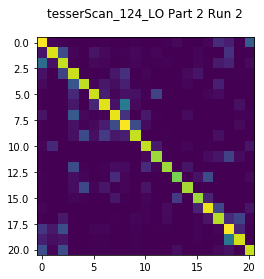

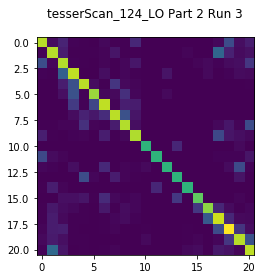

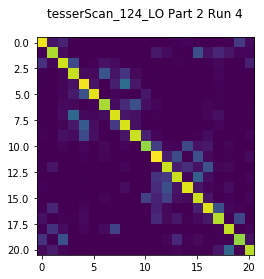

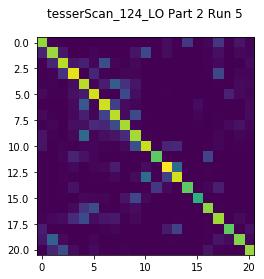

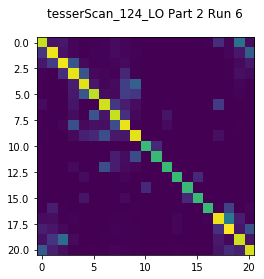

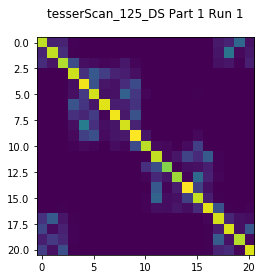

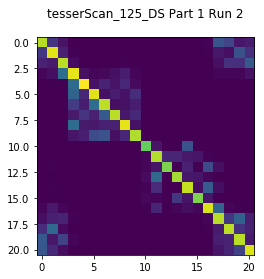

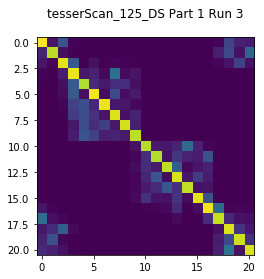

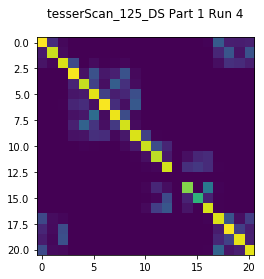

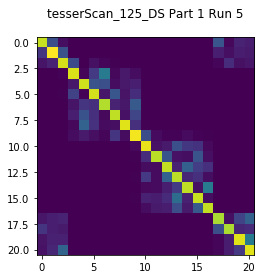

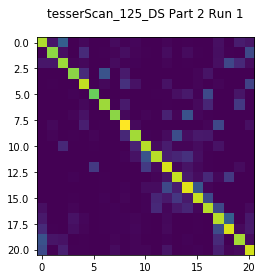

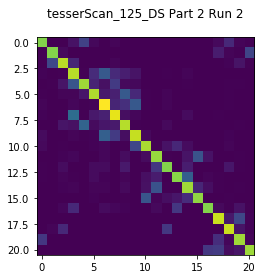

In [8]:
def make_plots(dir):
    
    envsteps= make_envstep(dir)
    part = dl[dir][-11]
    run = dl[dir][-5]
    M  = SRclass_nathum_exp1(envsteps, 0.5, 0.5) #W, mem, total_episodes

    return M


for i in range(len(dl)):
    
    part = int(dl[i][-11])
    run = int(dl[i][-5])
    m= make_plots(i)
    plt.imshow(m)
    plt.title(dl[i][:17] + " Part " + str(part) + " Run " + str(run) + "\n")
    plt.show()